
# f₀ Analysis - Polyphonic Singing

This notebook explores the pitch (fundamental frequency) of a traditional polyphonic folk recording.

I used `librosa.pyin()` to extract f₀ from the full mix, and I'll later compare individual mic tracks (solo voices).

- Recording analyzed: `BMI_UK17100223_mykolaiv_troitsko_safonove`
- Goal: Visualize pitch over time and observe melody, harmony, and gaps



### Next Steps: individual mic recordings
- Analyze the **individual mic recordings** to get cleaner, more stable pitch contours.
- Compare f₀ ranges between singers.
- Check for moments of harmony or divergence between parts.


Found 6 audio files in 'recordings'
[✓] Loaded cached features for MIC01


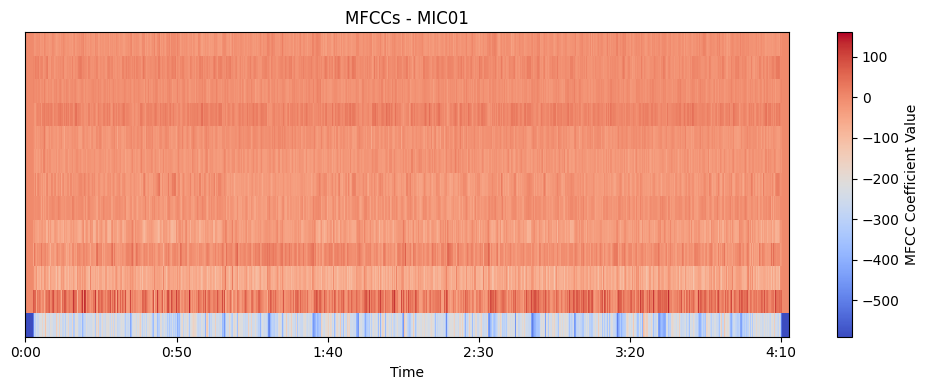

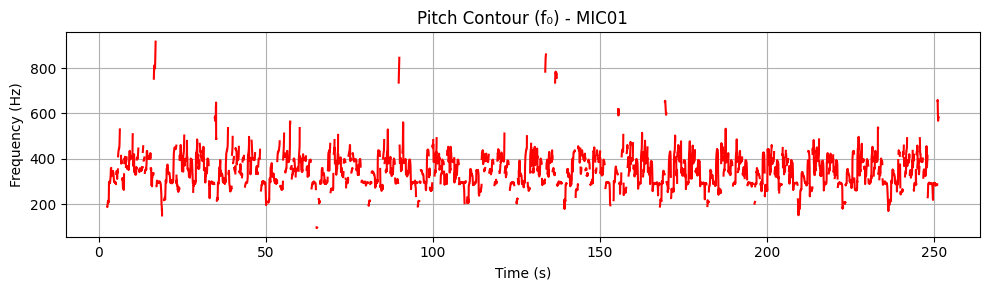

[✓] Loaded cached features for MIC02


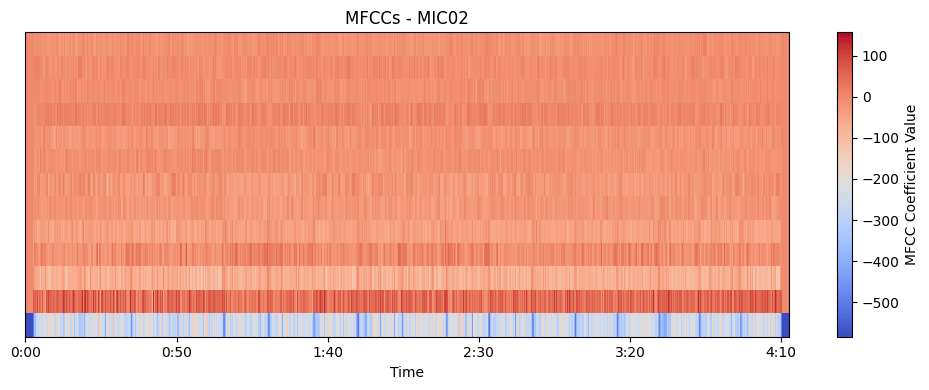

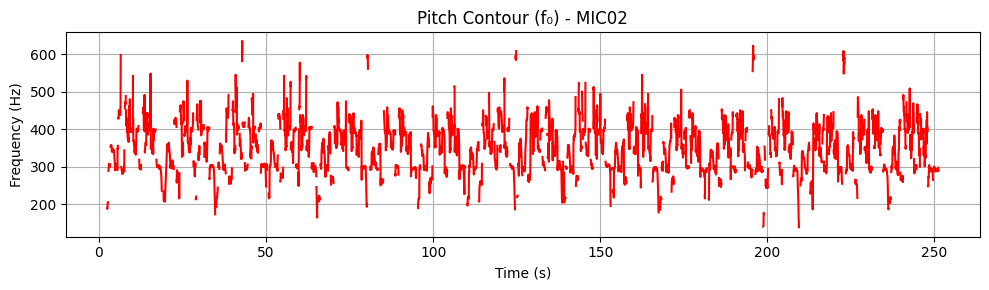

[✓] Loaded cached features for MIC03


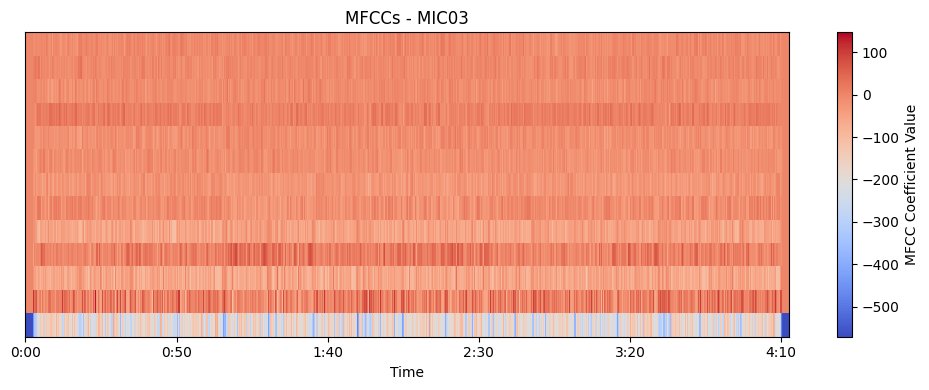

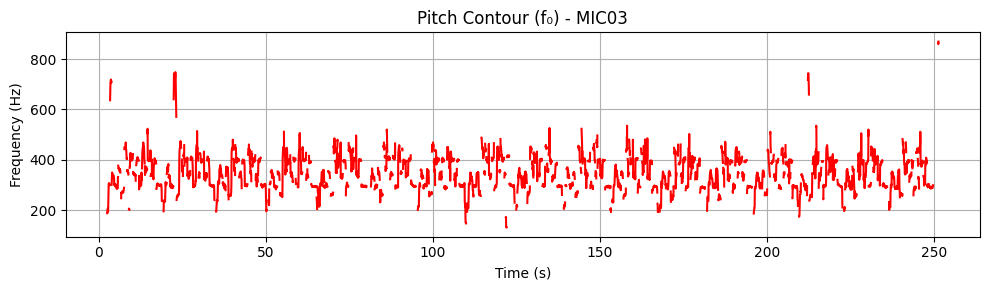

[✓] Loaded cached features for MIC04


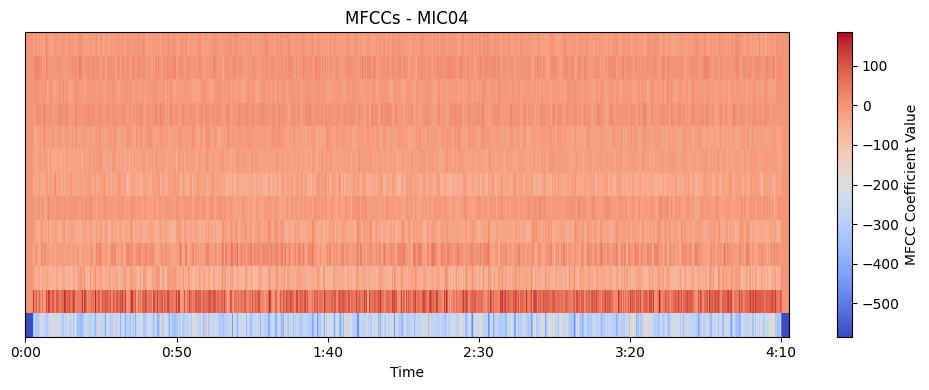

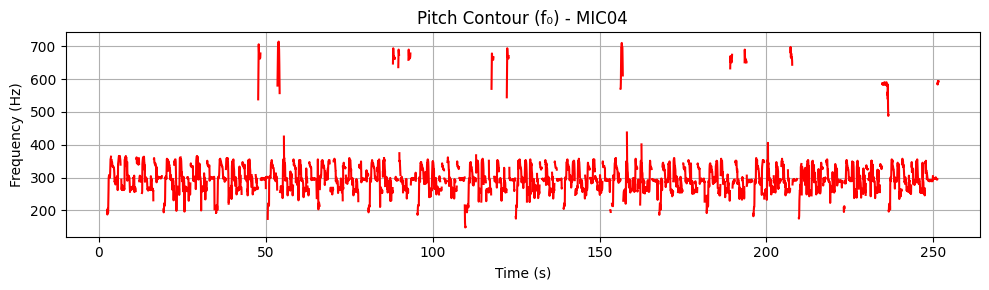

[✓] Loaded cached features for MIC05


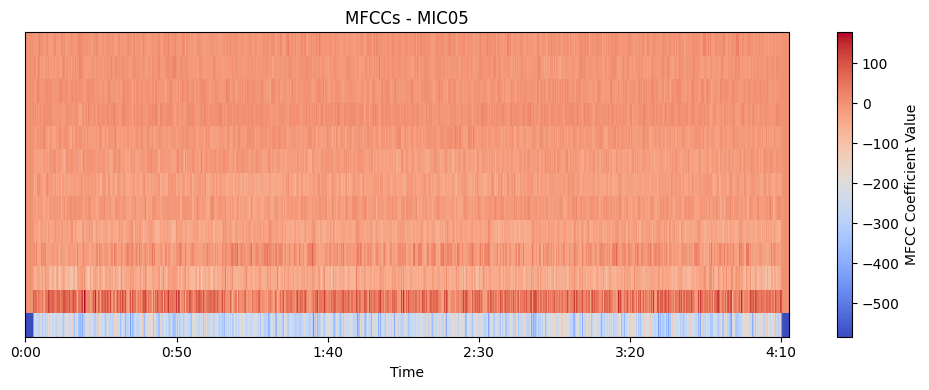

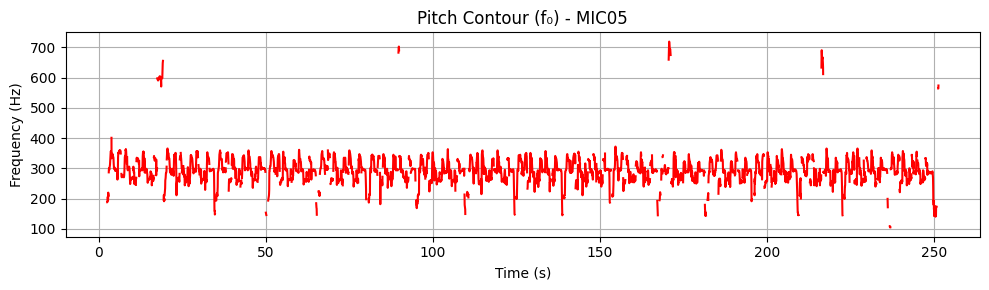

[✓] Loaded cached features for MIC06


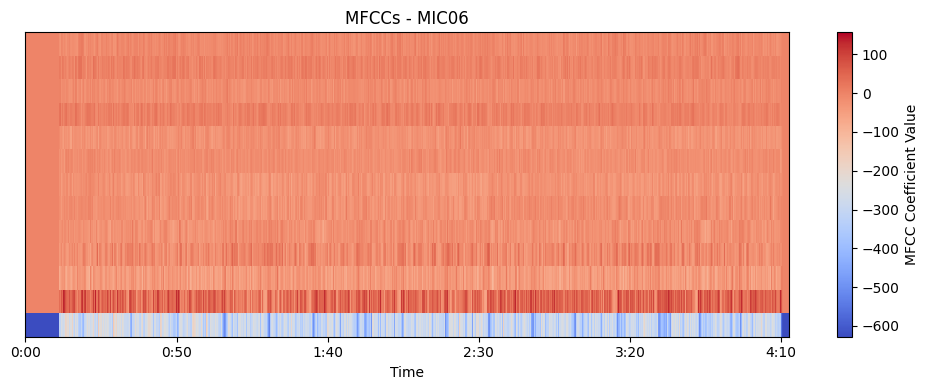

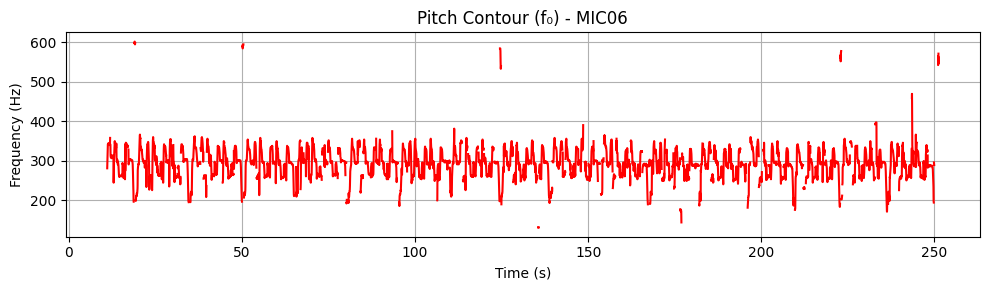

In [4]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import re

def extract_and_cache_all(recordings_dir="recordings", cache_dir="cache", sr=22050):
    os.makedirs(cache_dir, exist_ok=True)

    # Find all audio files
    audio_files = [
        f for f in os.listdir(recordings_dir)
        if f.lower().endswith(('.mp3', '.wav', '.flac', '.m4a'))
    ]

    print(f"Found {len(audio_files)} audio files in '{recordings_dir}'")
    features = {}

    for filename in audio_files:
        filepath = os.path.join(recordings_dir, filename)

        # Extract MIC label (e.g., MIC01)
        mic_match = re.search(r"(MIC\d+)", filename, re.IGNORECASE)
        if not mic_match:
            print(f"[!] Skipping file without MIC label: {filename}")
            continue

        mic_name = mic_match.group(1).upper()

        # Cache file paths
        f0_path = os.path.join(cache_dir, f"{mic_name}_f0.npy")
        mfcc_path = os.path.join(cache_dir, f"{mic_name}_mfcc.npy")

        # Load or compute features
        if os.path.exists(f0_path) and os.path.exists(mfcc_path):
            f0 = np.load(f0_path)
            mfcc = np.load(mfcc_path)
            print(f"[✓] Loaded cached features for {mic_name}")
        else:
            print(f"[→] Computing features for {mic_name} from '{filename}'...")
            y, sr = librosa.load(filepath, sr=sr)

            f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'),
                                       fmax=librosa.note_to_hz('C6'))
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

            np.save(f0_path, f0)
            np.save(mfcc_path, mfcc)
            print(f"[✓] Saved features to cache/ for {mic_name}")

        # Store in dict for later use
        features[mic_name] = {"f0": f0, "mfcc": mfcc, "filename": filename}

        # === Plot MFCCs ===
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, x_axis='time', sr=sr)
        plt.colorbar(label='MFCC Coefficient Value')
        plt.title(f'MFCCs - {mic_name}')
        plt.tight_layout()
        plt.show()

        # === Plot Pitch (f₀) ===
        times = librosa.times_like(f0)
        plt.figure(figsize=(10, 3))
        plt.plot(times, f0, label='f₀ (Hz)', color='r')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'Pitch Contour (f₀) - {mic_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return features

features = extract_and_cache_all()




🔁 Computing DTW distances between mic recordings...

DTW Distance Matrix (lower = more similar):

       MIC01   MIC02   MIC03   MIC04   MIC05   MIC06
MIC01        0   25397   32710   31172   29347   32972
MIC02    25397       0   32168   29630   28974   31906
MIC03    32710   32168       0   35900   33619   41317
MIC04    31172   29630   35900       0   26212   30130
MIC05    29347   28974   33619   26212       0   31053
MIC06    32972   31906   41317   30130   31053       0


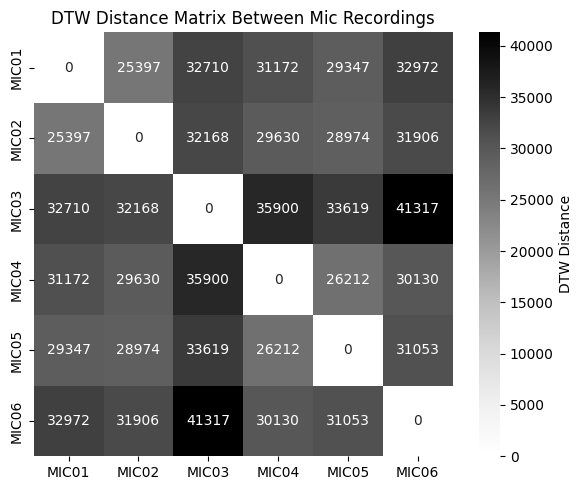

In [5]:
import os
import numpy as np
from librosa.sequence import dtw
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

def compare_all_mics_dtw(cache_dir="cache"):
    # Get all cached MFCC files
    mfcc_files = sorted([
        f for f in os.listdir(cache_dir)
        if f.endswith("_mfcc.npy")
    ])

    mic_names = [f.split("_")[0] for f in mfcc_files]
    mfcc_data = {mic: np.load(os.path.join(cache_dir, f"{mic}_mfcc.npy")).T for mic in mic_names}

    # Distance matrix
    n = len(mic_names)
    distance_matrix = np.zeros((n, n))

    print("🔁 Computing DTW distances between mic recordings...")
    for i, j in itertools.combinations(range(n), 2):
        mfcc_i = mfcc_data[mic_names[i]]
        mfcc_j = mfcc_data[mic_names[j]]
        D, _ = dtw(X=mfcc_i, Y=mfcc_j, metric='euclidean')
        dist = D[-1, -1]
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

    # Print DTW distance matrix (text)
    print("\nDTW Distance Matrix (lower = more similar):\n")
    print("      " + "  ".join(f"{name:>6}" for name in mic_names))
    for i, name in enumerate(mic_names):
        row = "  ".join(f"{distance_matrix[i, j]:6.0f}" for j in range(n))
        print(f"{name:<6}  {row}")

    # Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        distance_matrix,
        xticklabels=mic_names,
        yticklabels=mic_names,
        cmap="Greys",  # dark=close, light=far
        annot=True,
        fmt=".0f",
        cbar_kws={'label': 'DTW Distance'}
    )
    plt.title("DTW Distance Matrix Between Mic Recordings")
    plt.tight_layout()
    plt.show()

    return distance_matrix, mic_names

distance_matrix, mic_names = compare_all_mics_dtw()


        mic1 | mic2 | mic3 | mic4 | mic5 | mic6 |
mic1  |            
mic2  |
mic3  |
mic4  |
mic5  |
mic6  |